# Naural Networks Project

  *   Daniel Santos
  *   Maurício Sightman
  *   Paula Perazzo
  *   Pedro Manoel


## Data Processing

Before start implementing our model, we will first downaload, make a little exploration of the data we have and then process it in order to achieve a better model performance.

### Downloading

In [1]:
#installing dependency to hide unnecessary logs
!pip install gwpy --quiet
!pip install scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
!mkdir datasets

In [4]:
%%capture
!wget "https://drive.google.com/uc?id=1_MKWATwySO_pLbhTpKspsNgbzEy-i_Di&export=download" -O "train.csv.zip"
!unzip "train.csv.zip" -d "datasets"
!rm "train.csv.zip"

In [5]:
%%capture
!wget "https://drive.google.com/uc?id=166yA-LWwDM28SHkQFwiUX2hlwIBU-2ww&export=download" -O "test.csv.zip"
!unzip "test.csv.zip" -d "datasets"
!rm "test.csv.zip"

### Splitting

Here we will make separations of datasets in this way:


  *   70% of the trainning data for the trainning process
  *   30% of the trainning data for the validation process
  *   100% of the test data for the test process



In [6]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [7]:
train_dataset = pd.read_csv('datasets/train.csv')
test_dataset = pd.read_csv('datasets/test.csv')

validation_dataset = train_dataset.sample(frac=0.3, random_state=200)
train_dataset = train_dataset.drop(validation_dataset.index)

In [8]:
train_dataset = train_dataset.drop(['Unnamed: 0', 'id'], axis=1)
validation_dataset = validation_dataset.drop(['Unnamed: 0', 'id'], axis=1)
test_dataset = test_dataset.drop(['Unnamed: 0', 'id'], axis=1)

### Utils

In [9]:
def compare_boxplots(data, columns):
  width, total = 1/len(columns), len(columns)
  fig, ax = plt.subplots(1,total, figsize=(12, 5))
  for index, column in enumerate(columns):
    sns.boxplot(data[column], ax=ax[index%total], width=width)
  fig.show()

In [10]:
def remove_outliers_z_score(data, columns, threshold):
    z_scores = stats.zscore(data[columns])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    return data[filtered_entries]

In [11]:
def make_ranges(dataset, columns, partitions=6):
  new_df = dataset[columns]
  for column in columns:
    new_df[f'{column} Range'] = pd.cut(new_df[column], bins=partitions, labels=[f'Q{idx}' for idx in range(1, partitions+1)])
  return new_df

In [12]:
def make_histogram(dataset, options={}):
  sns.countplot(data=dataset, ax=options.get('ax'), x=options['x'], hue=options['hue'])
  if not options.get('ax'):
    plt.title(options.get('title'))
    plt.xlabel(options.get('xlabel'))
    plt.ylabel(options.get('ylabel'))
    plt.show()

In [13]:
def adjust_column_names(dataset):
  dataset = dataset.copy()
  names = {'Class_Business': 'Business (Class)', 'Class_Eco': 'Eco (Class)', 'Class_Eco Plus': 'Eco Plus (Class)', 'encoded satisfaction': 'satisfaction'}

  for column in dataset.columns:
    current = column
    if current in names: continue
    if 'Interval' in current:
      current = current.replace('Interval', '')
      split = current.split('_')
      current = f'{split[1]} ({split[0].strip()})'
    if '_' in current:
      split = current.split('_')
      current = f'{split[1]} ({split[0]})'

    names[column] = current.strip().title()

  return dataset.rename(columns=names)

### Exploring

Here we will look into our dataset in order to observe which data types is inserted on it, what are the distribution and take insights.

When exploring our data, we can notice that the column **Arrival Delay in Minutes** is the only one that have some missing data. But if we take a look in a few rows of our dataset we will also note that some range columns has value zero, but the range should probably be from 1 to 5, so these zero values also consist in missing values.

We can also notice that there are not duplicated rows in the dataset, and the data iself has a good balance between unsatisfied and satisfied instances (of course its not an equal partition, but the distance between them seems to not have a great misclassification impact)

In [14]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72733 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             72733 non-null  object 
 1   Customer Type                      72733 non-null  object 
 2   Age                                72733 non-null  int64  
 3   Type of Travel                     72733 non-null  object 
 4   Class                              72733 non-null  object 
 5   Flight Distance                    72733 non-null  int64  
 6   Inflight wifi service              72733 non-null  int64  
 7   Departure/Arrival time convenient  72733 non-null  int64  
 8   Ease of Online booking             72733 non-null  int64  
 9   Gate location                      72733 non-null  int64  
 10  Food and drink                     72733 non-null  int64  
 11  Online boarding                    72733 non-null  int64  

In [15]:
print(f'DUPLICATED INSTANCES COUNT: {train_dataset[train_dataset.duplicated()].shape[0]}')

DUPLICATED INSTANCES COUNT: 0


<Axes: xlabel='satisfaction', ylabel='count'>

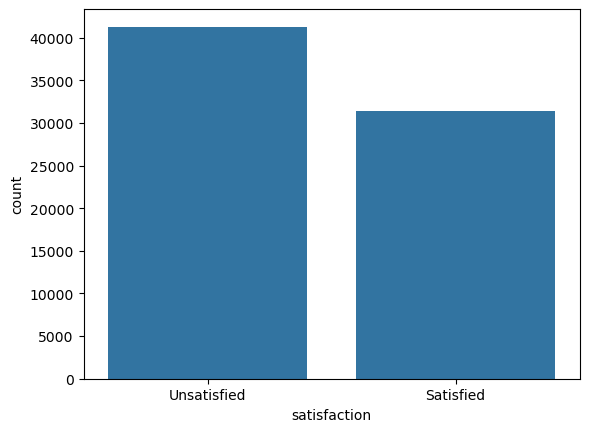

In [16]:
sns.countplot(data=train_dataset['satisfaction'].apply(lambda label: 'Satisfied' if label == 'satisfied' else 'Unsatisfied').to_frame(), x='satisfaction')

### Train Dataset

First of all, we will split our variables according to its data type and representation for the problem (note that we are not considering the satisfaction column since it is our result and it will not be dealed as a categorical variable). After that we will start our pre processing state handling missing data.

Here we will use two different approaches:
  1. use the mean value of each range column to fill its zero values (because we are considering the range from 1 to 5)
  2. use the median of the values from the **Arrival Delay in Minutes** column to fill its missing values.

In [17]:
FREE_VARIABLES = ['Arrival Delay in Minutes', 'Departure Delay in Minutes', 'Flight Distance', 'Age']
CATEGORICAL_VARIABLES = list(filter(lambda x: x != 'satisfaction', train_dataset.select_dtypes(include='object').columns.tolist()))
SCORE_VARIABLES = list(filter(lambda x: x not in FREE_VARIABLES, train_dataset.select_dtypes(include='int64').columns.tolist()))

In [18]:
adjust_type = lambda x: int(x)
train_dataset['Arrival Delay in Minutes'].fillna(train_dataset['Arrival Delay in Minutes'].mean(), inplace=True)
train_dataset['Arrival Delay in Minutes'] = train_dataset['Arrival Delay in Minutes'].apply(adjust_type)

for column in SCORE_VARIABLES:
    median_value = train_dataset[column][train_dataset[column] != 0].median()
    train_dataset[column] = train_dataset[column].replace(0, median_value)

Once the missing data was handled, we need to analyze the outliers values to start our normalization process. Lets see the distribution of the **Flight Distance** and **Age** variables. With a simple look at the graph we can notice that:
  1. on the **Flight Distance**, some outliers start to appear near 4000
  2. on the **Age** it seems that are no outliers, but we can stablish a limiar of 80 years old, since there is few instances of data greater than this value

C:\Users\mpps\AppData\Local\Temp\ipykernel_23696\1337670739.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


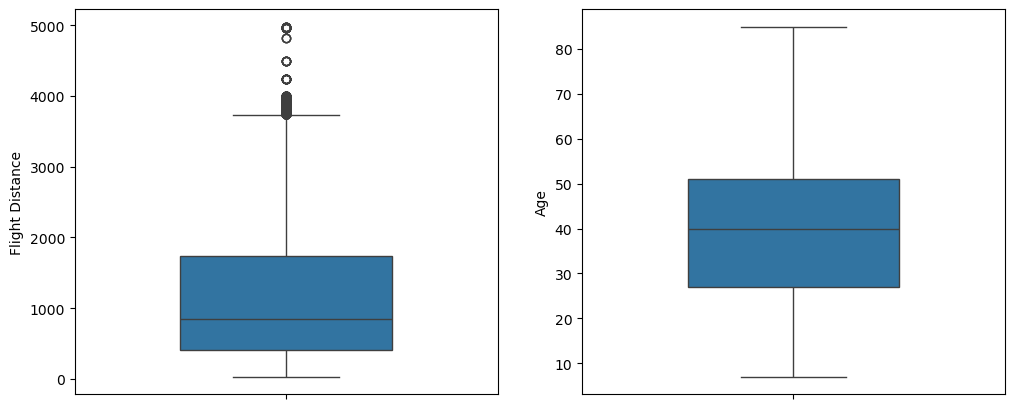

In [19]:
compare_boxplots(train_dataset, ['Flight Distance', 'Age'])

To handle outliers in the **Flight Distance** column we will use the **z-score** method, that takes in consideration the mean of the values and the standard deviation to cut out some edges based on a given threshold. To know more about the **z-score** method you can refer to [this link](https://www.linkedin.com/pulse/z-score-normalization-ml-concepts-com/).

After the application of the **z-score** method we observe that the number of samples in the resultant dataset is decreased, and looking to the updated boxplot we can see that **Flight Distance** column has no outliers.

In [20]:
processed_dataset = remove_outliers_z_score(train_dataset, ['Flight Distance'], 2)
processed_dataset = processed_dataset[processed_dataset['Age'] <= 80]
processed_dataset.shape, train_dataset.shape

((67982, 23), (72733, 23))

C:\Users\mpps\AppData\Local\Temp\ipykernel_23696\1337670739.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


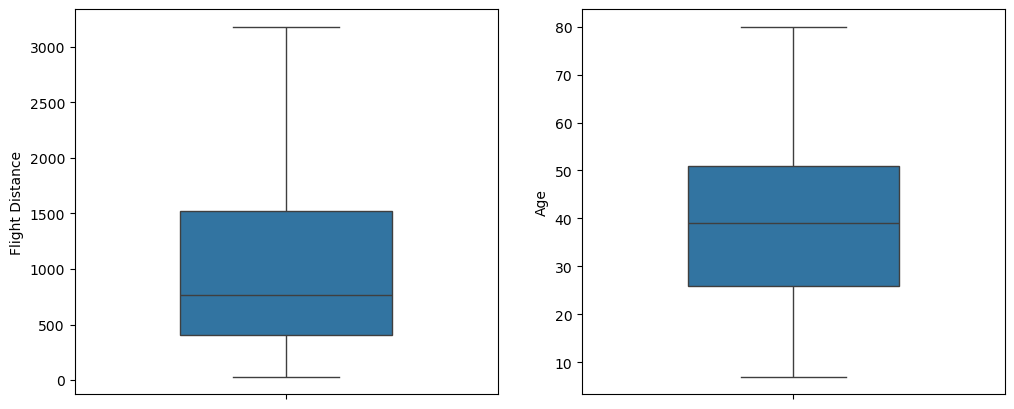

In [21]:
compare_boxplots(processed_dataset, ['Flight Distance', 'Age'])

When alanyzing the **Arrival Delay in Minutes** and **Departure Delay in Minutes** variables, we see how scattered those variables are, because there is no clear standard deviation neither median of values. We will need to go deeper to extract some knowledge about these variables.

C:\Users\mpps\AppData\Local\Temp\ipykernel_23696\1337670739.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


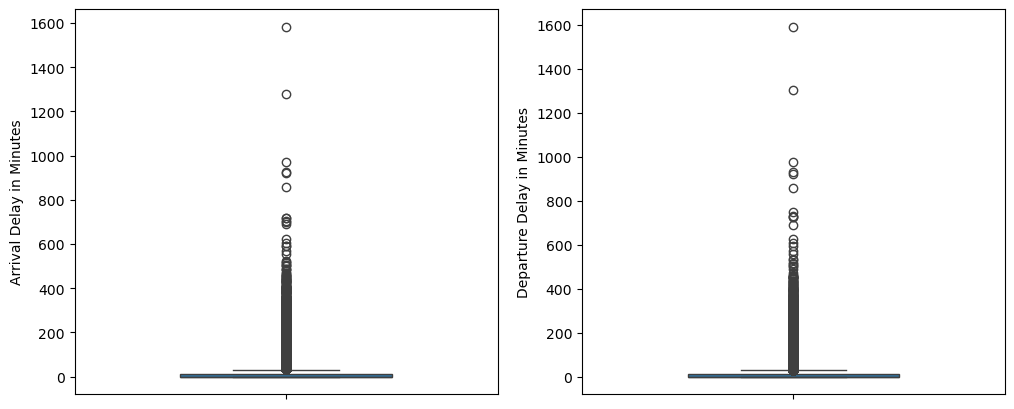

In [22]:
DELAY_VARIABLES = ['Arrival Delay in Minutes', 'Departure Delay in Minutes']
compare_boxplots(processed_dataset, DELAY_VARIABLES)

Verifying the correlation of both variables with the satisfaction, we can see that it is near zero, and what means that alone it has almost none impact at all, but it can have impact when associated with others variables (if it is the case, our model performance must be improved when using them. If not, the model will not be affected when removing them). Given the intrinsic relation between those variables and the how similar they are in terms of distribution and impact, we will use the **Arrival Delay in Minutes** column as base and then transfer the knowledge to the **Departure Delay in Minutes**.

*Notice that most of the values are zeros, which justifies that strange boxplot abox, because the median was set too low and also the limiar for outliers.



In [23]:
processed_dataset['encoded satisfaction'] = processed_dataset['satisfaction'].apply(lambda x: 2 if x == 'satisfied' else 1)

In [24]:
arrival_correlation = processed_dataset['Arrival Delay in Minutes'].corr(processed_dataset['encoded satisfaction'])
departure_correlation = processed_dataset['Departure Delay in Minutes'].corr(processed_dataset['encoded satisfaction'])
print(f'arrival: {arrival_correlation}, departure: {departure_correlation}')

arrival: -0.05914878595388675, departure: -0.0545366805820075


In [25]:
zeros = processed_dataset[processed_dataset['Arrival Delay in Minutes'] == 0].shape[0]
non_zeros = processed_dataset[processed_dataset['Arrival Delay in Minutes'] > 0].shape[0]
zeros, non_zeros

(38004, 29978)

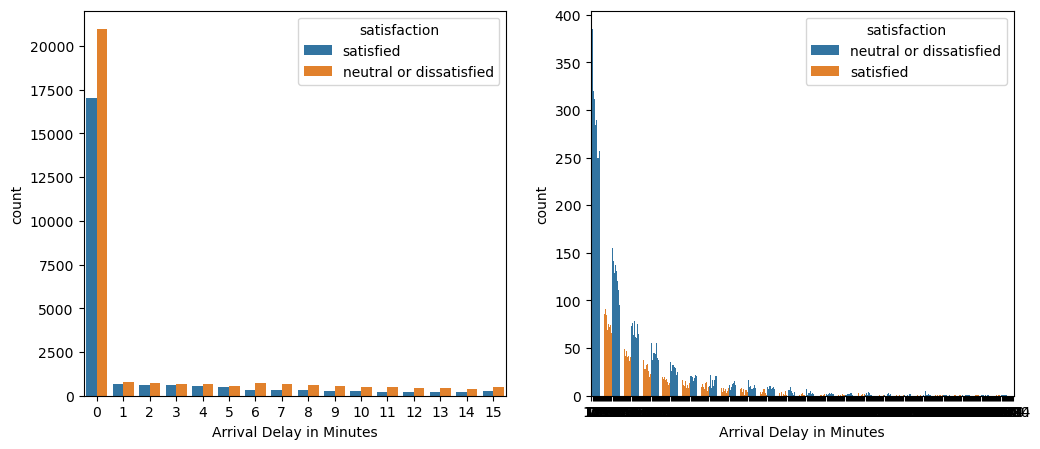

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

smaller_interval = processed_dataset[processed_dataset['Arrival Delay in Minutes'] <= 15]
smaller_options = {'x': 'Arrival Delay in Minutes', 'hue': 'satisfaction', 'ax': ax[0]}

bigger_interval = processed_dataset[processed_dataset['Arrival Delay in Minutes'] > 15]
bigger_options = {'x': 'Arrival Delay in Minutes', 'hue': 'satisfaction', 'ax': ax[1]}

make_histogram(smaller_interval, smaller_options)
make_histogram(bigger_interval, bigger_options)
plt.show()

Observing the behaviour of the variable with different values we can notice that it is nearly proportional along the instances, which gives more sense to the fact of the almost zero correlation.

Due the visualization of the past boxplot, when we notice that values start to be more sparse near **600 minutes**, we will stablish that value as limiar here. So now we can define some intervals of data like so:


  *  **= 0:** no delay
  *  **1 - 30:** short delay
  *  **31 - 60:** medium delay
  *  **> 60:** long delay

In [27]:
processed_dataset = processed_dataset[processed_dataset['Arrival Delay in Minutes'] <= 600]
processed_dataset = processed_dataset[processed_dataset['Departure Delay in Minutes'] <= 600]

In [28]:
def delay_segmentation(x):
  if x == 0: return 'No Delay'
  if x <= 30: return 'Short Delay'
  if x <= 60: return 'Medium Delay'
  return 'Long Delay'

processed_dataset['Arrival Interval'] = processed_dataset['Arrival Delay in Minutes'].apply(delay_segmentation)
processed_dataset['Departure Interval'] = processed_dataset['Departure Delay in Minutes'].apply(delay_segmentation)

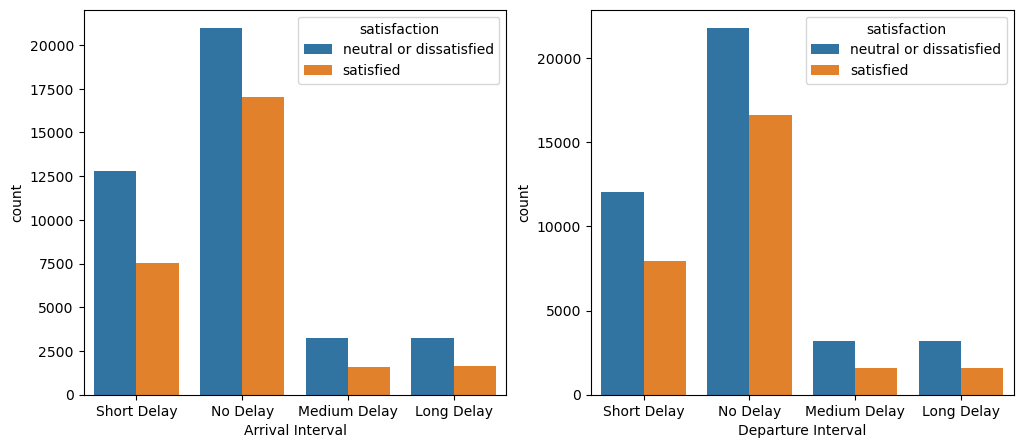

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

arrival_options = {'x': 'Arrival Interval', 'hue': 'satisfaction', 'ax': ax[0]}
departure_options = {'x': 'Departure Interval', 'hue': 'satisfaction', 'ax': ax[1]}

make_histogram(processed_dataset, arrival_options)
make_histogram(processed_dataset, departure_options)
plt.show()

Let's do the same process to find intervals for age, but using a different visualization for that. Visualizing the graph we can see that maybe a 20 years interval could be good, because:


  *   **0 - 20:** we cover the predominance of dissatisfaction
  *   **20 - 40**: we cover the transition between dissatisfaction and satisfaction
  *   **40 - 60:** we cover the predominance of the satisfaction
  *   **> 60:** we cover the comeback of most dissatisfaction



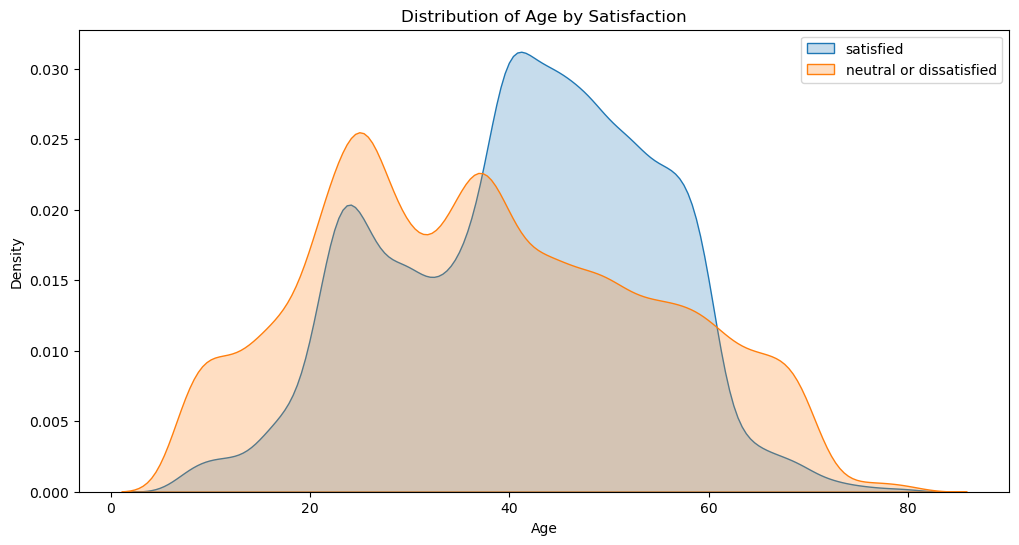

In [30]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=processed_dataset[processed_dataset['encoded satisfaction'] == 2], x='Age', label='satisfied', fill=True)
sns.kdeplot(data=processed_dataset[processed_dataset['encoded satisfaction'] == 1], x='Age', label='neutral or dissatisfied', fill=True)
plt.title('Distribution of Age by Satisfaction')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

In [31]:
def age_segmentation(x):
  if x <= 20: return 'Youth'
  if x <= 40: return 'Adults'
  if x <= 60: return 'Middle-Aged'
  return 'Senior'

processed_dataset['Age Interval'] = processed_dataset['Age'].apply(age_segmentation)

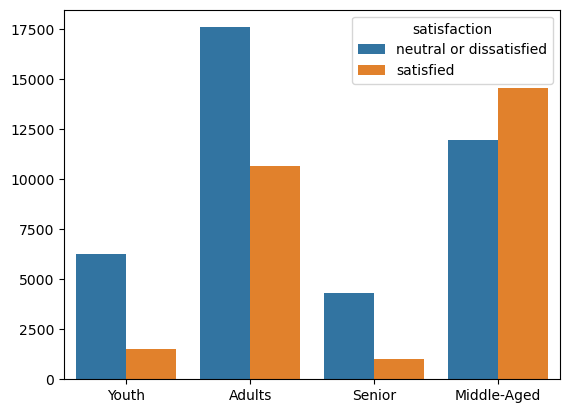

In [32]:
age_options = {'x': 'Age Interval', 'hue': 'satisfaction'}
make_histogram(processed_dataset, age_options)

Still about intervals, now we will focus on the Flight Distance, our last free variable. Here we will considere 5 intervals, like so:


  *   **0 - 500:** tendency of increase for both variables
  *   **501 - 1000:** tendency of decrease for both variables
  *   **1001 - 1500:** satisfaction overtakes dissatisfaction
  *   **1501 - 2500:** both variables presents little instability
  *   **> 2500:** both variables decrease on advanced rate



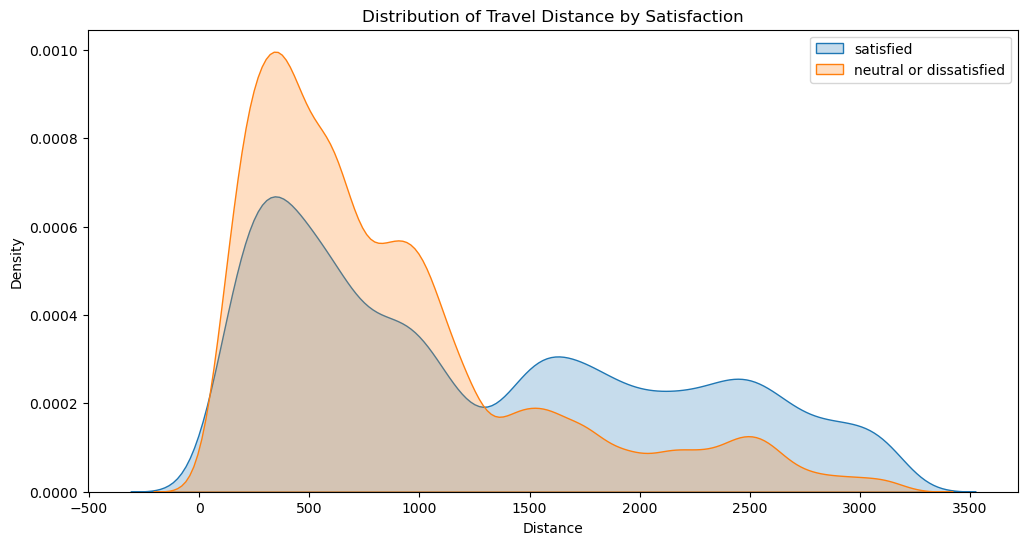

In [33]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=processed_dataset[processed_dataset['encoded satisfaction'] == 2], x='Flight Distance', label='satisfied', fill=True)
sns.kdeplot(data=processed_dataset[processed_dataset['encoded satisfaction'] == 1], x='Flight Distance', label='neutral or dissatisfied', fill=True)
plt.title('Distribution of Travel Distance by Satisfaction')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.legend()
plt.show()

In [34]:
def distance_segmentation(x):
  if x <= 500: return 'Short'
  if x <= 1000: return 'Moderate'
  if x <= 1500: return 'Mid-Range'
  if x <= 2500: return 'Long'
  return 'Extended'

processed_dataset['Flight Distance Interval'] = processed_dataset['Flight Distance'].apply(distance_segmentation)

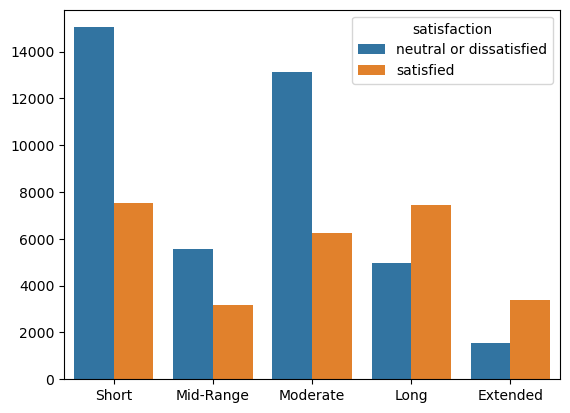

In [35]:
distance_options = {'x': 'Flight Distance Interval', 'hue': 'satisfaction'}
make_histogram(processed_dataset, distance_options)

Notice that along this process our free variables became categorical variables, so we will remove the original columns and considere the new ones as categorical

In [36]:
COLUMNS_TO_REMOVE = FREE_VARIABLES + ['satisfaction']
processed_dataset = processed_dataset.drop(columns=COLUMNS_TO_REMOVE)
CATEGORICAL_VARIABLES += ['Flight Distance Interval', 'Age Interval', 'Arrival Interval', 'Departure Interval']

Now we will encode our categorical variables

In [37]:
processed_dataset = pd.get_dummies(processed_dataset, columns=CATEGORICAL_VARIABLES)

Now, let's considere the processed_dataset our training dataset and to some instances or our data

In [38]:
train_dataset = adjust_column_names(processed_dataset)
train_dataset.head()

,Inflight Wifi Service,Departure/Arrival Time Convenient,Ease Of Online Booking,Gate Location,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-Board Service,Leg Room Service,...,Senior (Age),Youth (Age),Long Delay (Arrival),Medium Delay (Arrival),No Delay (Arrival),Short Delay (Arrival),Long Delay (Departure),Medium Delay (Departure),No Delay (Departure),Short Delay (Departure)
0,3,4,3,1,5,3,5,5,4,3,...,False,True,False,False,False,True,False,False,False,True
1,3,2,3,3,1,3,1,1,1,5,...,False,False,False,False,False,True,False,False,False,True
2,2,2,2,2,5,5,5,5,4,3,...,False,False,False,False,True,False,False,False,True,False
3,2,5,5,5,2,2,2,2,2,5,...,False,False,False,False,False,True,False,False,False,True
4,3,3,3,3,4,5,5,3,3,4,...,True,False,False,False,True,False,False,False,True,False


In [49]:
train_dataset["satisfaction"]

0         1
1         1
2         2
3         1
4         2
         ..
103899    1
103900    2
103901    1
103902    1
103903    1
Name: satisfaction, Length: 67968, dtype: int64

In [48]:
train_dataset.to_csv('datasets/train_processed.csv', index=False)

### Validation and Test Datasets

First we will fill the missing values on the remaining datasets

In [39]:
others_datasets = { 'validation': validation_dataset, 'test': test_dataset }

In [40]:
for key in list(others_datasets.keys()):
  current = others_datasets[key].copy()
  current['Arrival Delay in Minutes'].fillna(current['Arrival Delay in Minutes'].mean(), inplace=True)

  for column in SCORE_VARIABLES:
      median_value = current[column][current[column] != 0].median()
      current[column] = current[column].replace(0, median_value)

  others_datasets[key] = current

Let's encode our satisfaction column

In [41]:
for key in list(others_datasets.keys()):
  current = others_datasets[key].copy()
  current['encoded satisfaction'] = current['satisfaction'].apply(lambda x: 2 if x == 'satisfied' else 1)
  others_datasets[key] = current

Now, for the free variables, we need to apply the same intervals of the trainning dataset

In [42]:
for key in list(others_datasets.keys()):
  current = others_datasets[key].copy()
  current['Arrival Interval'] = current['Arrival Delay in Minutes'].apply(delay_segmentation)
  current['Departure Interval'] = current['Departure Delay in Minutes'].apply(delay_segmentation)
  current['Flight Distance Interval'] = current['Flight Distance'].apply(distance_segmentation)
  current['Age Interval'] = current['Age'].apply(age_segmentation)
  others_datasets[key] = current

Let's also remove the original free variable columns

In [43]:
for key in list(others_datasets.keys()):
  current = others_datasets[key].copy()
  current = current.drop(columns=COLUMNS_TO_REMOVE)
  others_datasets[key] = current

Adapting categorical variables with one-hot encoding method

In [44]:
for key in list(others_datasets.keys()):
  current = others_datasets[key].copy()
  current = pd.get_dummies(current, columns=CATEGORICAL_VARIABLES)
  others_datasets[key] = current

Finally let's apply the column names standard so the whole structure of the remaining datasets can follow the trainning dataset

In [45]:
for key in list(others_datasets.keys()):
  others_datasets[key] = adjust_column_names(others_datasets[key].copy())

In [46]:
for key in list(others_datasets.keys()):
  print(f'{key} shape: {others_datasets[key].shape}')

validation shape: (31171, 41)
test shape: (25976, 41)


In [52]:
others_datasets["validation"].to_csv('datasets/validation_processed.csv', index=False)
others_datasets["test"].to_csv('datasets/test_processed.csv', index=False)